# <center>TP2 :  k-plus proches voisins, analyse discriminante et régression logistique</center> ([sujet](knn_lda_logreg.pdf))
---

In [1]:
from functools import partial # useful for weighted distances
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import metrics
from scipy import stats  # to use scipy.stats.mode
from sklearn import neighbors
from sklearn import datasets
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tpknnsource import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d, ErrorCurve,
                           frontiere_new, LOOCurve)


import seaborn as sns
from matplotlib import rc

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (7, 5)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("cool")
sns.set_style("white")

## Génération artificielle de données
***
### Question 1
 Étudiez les fonctions *rand_bi_gauss*, *rand_tri_gauss*, *rand_clown* et *rand_checkers*. Que renvoient ces fonctions ? À quoi correspond la dernière colonne?  
 Générez les données en utilisant chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour rand_checkers générez 150 observations dans chaque classe ; pour *rand_tri_gauss* générez 50 observations dans chaque classe, centrées en (1, 1)$^T$, (−1, −1)$^T$ et (1, −1)$^T$, tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [2]:
#Fixe la seed de manière globale
np.random.seed(47) 

n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
X3, y3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = rand_checkers(n1, n2, sigma)

### Question 2
 Utilisez la fonction *plot_2d* afin d’afficher les jeux de données générés avec chacune des fonctions.

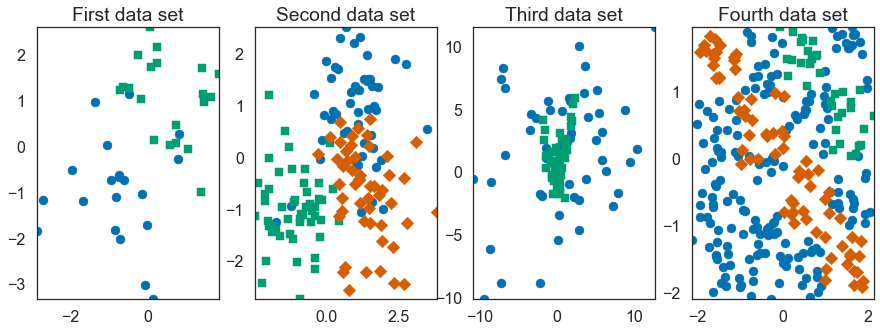

In [3]:
plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.subplot(141)
plt.title('First data set')
plot_2d(X1, y1)

plt.subplot(142)
plt.title('Second data set')
plot_2d(X2, y2)

plt.subplot(143)
plt.title('Third data set')
plot_2d(X3, y3)

plt.subplot(144)
plt.title('Fourth data set')
plot_2d(X4, y4)

## Approche intuitive
***
### Question 3
 Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y sont à valeurs réelles : Y = R.

<div style="border-style:dotted; border-width:2px; padding: 25px 50px;">**Réponse : **  
Pour la regression on peut essayer une version similaire. Evidemment prendre la classe majoritaire des voisins ne fonctionnera pas. Au lieu de prendre la classe majoritzire, on peut prendre la moyenne des classes des k voisins du point à prédire.</div> 

## Approche formelle
***
### Question 4 
  Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans Vk(x). Vérifier la validité des résultats en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test). Vous pouvez utilisez le bloc de code si-dessous en complétant le méthodes proposées. Pour plus d’information sur les classes on peut consulter par exemple http://docs.python.org/3/tutorial/classes.html.

In [4]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    '''Homemade Nearest neighbors classifier'''
    
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        distance = metrics.pairwise.euclidean_distances(X,self.X_)
        distance_sorted_indexes = np.argsort(distance)
        neighbours_labels = self.y_[distance_sorted_indexes[0:self.n_neighbors]]
        predicted_label = stats.mode(neighbours_labels)
        return predicted_label[0][0]
        

### Question 5
Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant
la distance euclidienne classique $d$(x, v) = ||x − v||$_2$ et k = 5. Visualisez les règles de classification
obtenues en utilisant la fonction frontiere_new. (Souvent, les autres choix de distance peuvent
être utiles, par exemple la distance de Mahalanobis.)

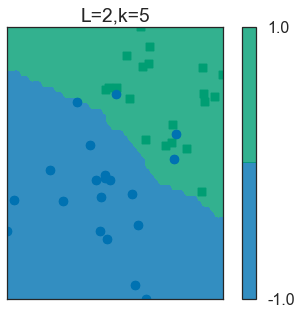

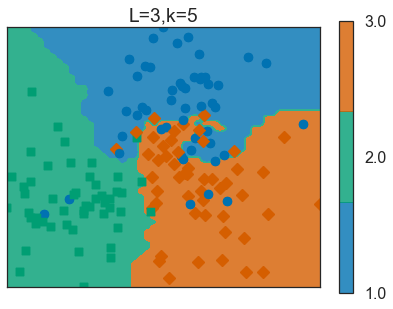

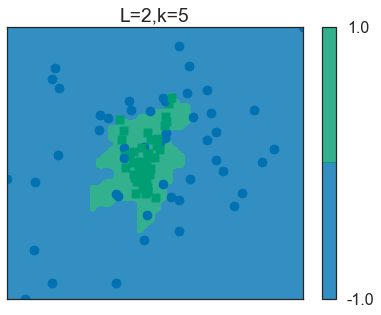

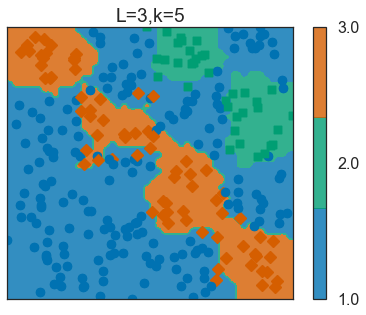

In [5]:
plt.close()
n_neighbors = 5  # the k in k-NN
#Création du KNN de sklearn
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

for X, y in [(X1, y1), (X2, y2), (X3, y3), (X4, y4)]:

    def f(xx):
        return knn.predict(xx.reshape(1, -1))
    
    #Fitting des données  
    knn.fit(X, y)
    
    #Affichage des données 
    plt.figure()
    plot_2d(X, y)
    n_labels = np.unique(y).shape[0]
    frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, n_labels=n_labels,
                  n_neighbors=n_neighbors)

### Question 6
Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris
en compte : k = 1, 2, . . . , n. Que devient la méthode dans le cas extrême où k = 1 ? k = n ? Afficher
ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une
forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

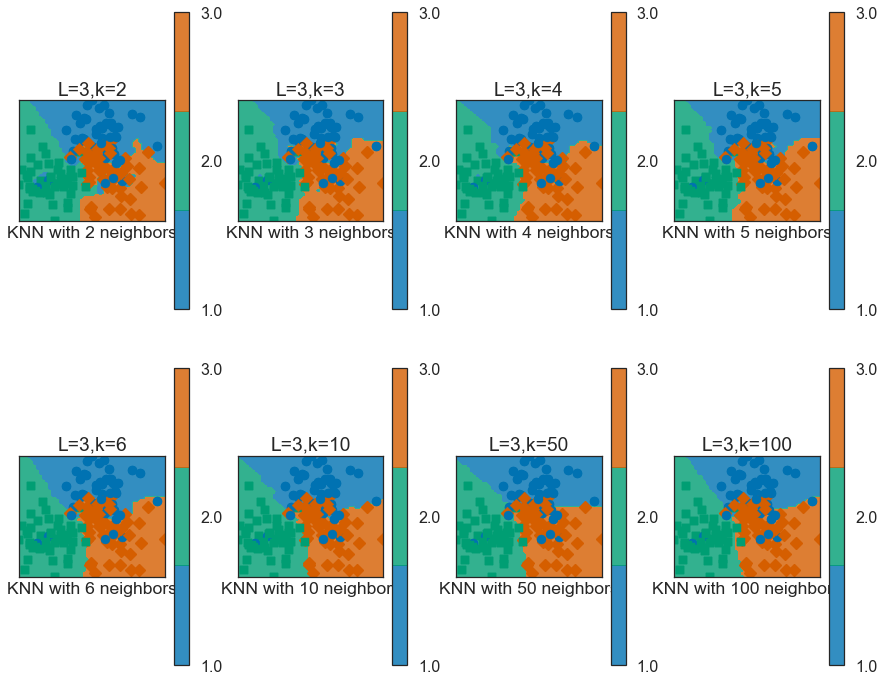

In [6]:
#Création des différents k à tester
rng = np.arange(2,7)
rng = np.append(rng,[10,50,100])
plt.close()
plt.figure(figsize=(15,12))
#Pour afficher les plots de manière plus esthétique
spp = [241,242,243,244,245,246,247,248]
i = 0

#Affichage des données
for k in rng:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    def f(xx):
        return knn.predict(xx.reshape(1, -1))
    knn.fit(X2,y2)
    plt.subplot(spp[i])
    i += 1
    plt.xlabel('KNN with ' + str(k) + ' neighbors')
    plot_2d(X2,y2)
    n_labels = np.unique(y).shape[0]
    frontiere_new(f, X2, y2, w=None, step=50, alpha_choice=1, n_labels=n_labels,
                  n_neighbors=k)

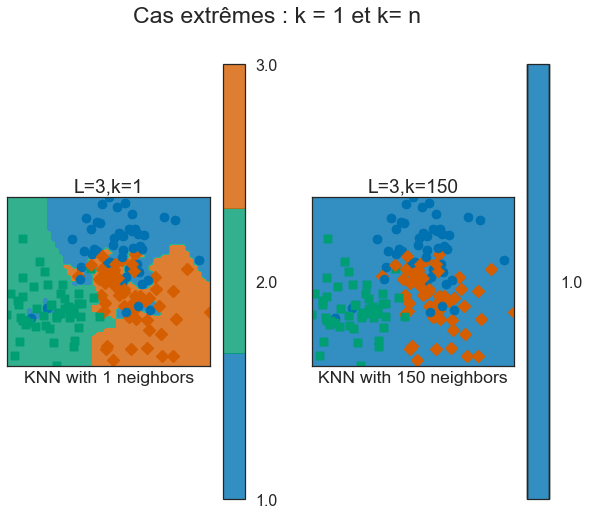

In [7]:
plt.close()
fig = plt.figure(figsize=(10,8))
fig.suptitle('Cas extrêmes : k = 1 et k= n')
rng2 = [1,150]
spp2 = [121,122]
j = 0
for k in rng2:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    def f(xx):
        return knn.predict(xx.reshape(1, -1))
    knn.fit(X2,y2)
    plt.subplot(spp2[j])
    j += 1
    plt.xlabel('KNN with ' + str(k) + ' neighbors')
    plot_2d(X2,y2)
    n_labels = np.unique(y).shape[0]
    frontiere_new(f, X2, y2, w=None, step=50, alpha_choice=1, n_labels=n_labels,
                  n_neighbors=k)

> On remarque que plus on augmente le nombre de de voisins à séléctionner, plus la frontière devient simple. 
dans le cas extrême où $k = 1$, on overfit le modèle et **chaque point à le bon label qui est prédit.**  
Dans le cas $k = 50$ ( donc $k = n$ ) on prédit seulement le label majoritaire dans les données (ici le **label 1**) 

### Question 7
Une variante possible très utilisée consiste à pondérer les poids du $jème$ voisin selon $e^{−d^2_j/h}$ (h
contrôlant le niveau de pondération) : cela revient à remplacer l’Équation (2) par :

$\hat{f}_k(x) \in argmax_{y=\gamma} (\sum_{j=1}^k{ exp(d^2_j/h) \mathbb{1}_{\{y_{rj}=y\}}})$

Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeur
de KNeighborsClassifier. (Une autre possibilité consiste à pondérer les variable et non seulement
les observations, on le regarde pas ici.) On pourra s’inspirer de _weight_func de la partie
test de scikit-learn : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/tests/test_neighbors.py. Pour tester l’impact du choix de h sur les frontières de classification,
visualisez les règles de classification pour k = 7 et h = 10^j avec j = -2;-1; 0; 1; 2 ; utilisez
les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur (Vous pouvez
utiliser la fonction frontiere_new.)

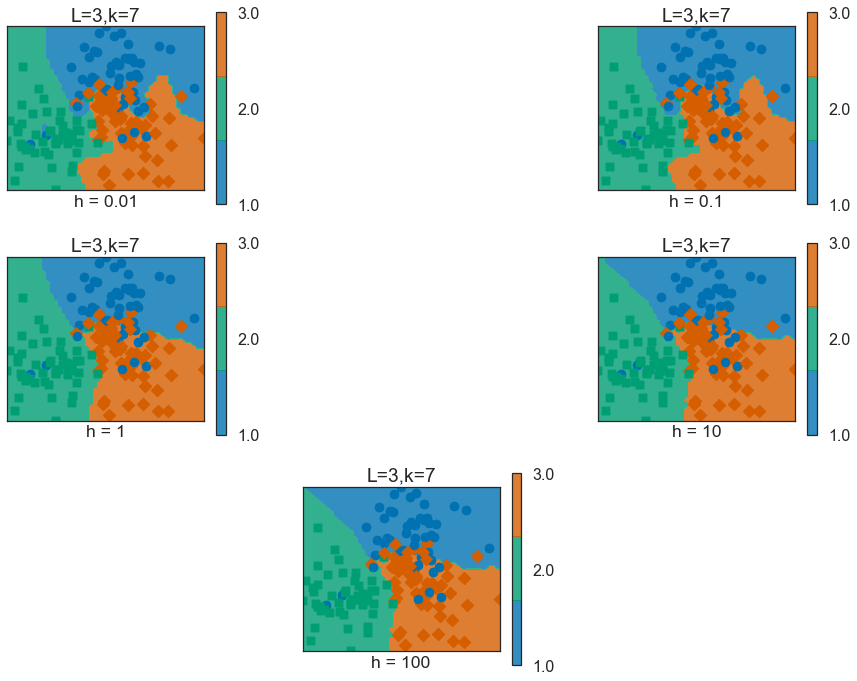

In [8]:
def custom_weight(dist):
    return np.exp(-(dist ** 2)/h)
sp = [331,333,334,336,338]
k = 0
plt.close()
plt.figure(figsize=(15,12))
for j in range(-2,3):
    h = 10 ** j
    weighted_knn_1 = neighbors.KNeighborsClassifier(n_neighbors=7, weights=custom_weight)
    weighted_knn_1.fit(X2[0::2],y2[0::2])
    def f(xx):
        return weighted_knn_1.predict(xx.reshape(1, -1))
    plt.subplot(sp[k])
    k += 1
    plt.xlabel('h = ' + str(h))
    plot_2d(X2,y2)
    n_labels = np.unique(y).shape[0]
    frontiere_new(f, X2, y2, w=None, step=50, alpha_choice=1, n_labels=n_labels,
                  n_neighbors=7)

### Question 8
Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite
par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [9]:
error_df = pd.DataFrame(columns=["h","train_error","test_error"]) 
k = 0
for j in range(-2,3):
    data = []
    h = 10 ** j
    data.append(h)
    weighted_knn_2 = neighbors.KNeighborsClassifier(n_neighbors=1, weights=custom_weight)
    weighted_knn_2.fit(X2[0::2],y2[0::2])
    data.append(np.mean(weighted_knn_2.predict(X2[0::2]) != y2[0::2]) )
    data.append(np.mean(weighted_knn_2.predict(X2) != y2))
    error_df.loc[k] = data
    k += 1
print("Tableau du taux d'erreur sur les données d'apprentissage et de test lorsque k = 1" )
error_df

Tableau du taux d'erreur sur les données d'apprentissage et de test lorsque k = 1


,h,train_error,test_error
0,0.01,0.0,0.12
1,0.10,0.0,0.12
2,1.00,0.0,0.12
3,10.00,0.0,0.12
4,100.00,0.0,0.12


### Question 9
 Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations
d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50.
Vous pourrez utiliser la classe fournie *ErrorCurve*.

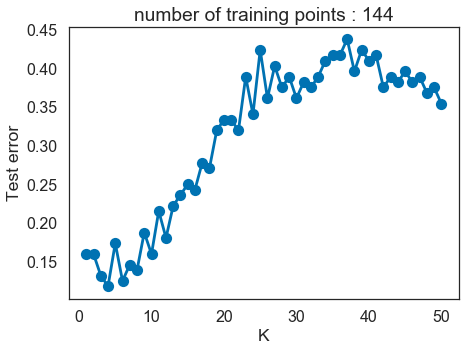

In [10]:
plt.close()
errorCurve = ErrorCurve(k_range=range(1,51), weights=custom_weight)
errorCurve.fit_curve(X4[::2],y4[0::2],X4[1::2],y4[1::2])
errorCurve.plot()

### Question 10 
Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, 2, . . . , 50) sur le jeu de
données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à
1000\. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même
taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ? Vous pourrez
utiliser la classe fournie ErrorCurve. Pour n = 1000 visualisez les données et la règle de décision
sur le même graphique. (Vous pouvez utiliser la fonction frontiere_new.)

Pour n = 100 échantillons, k = 11 est la meilleure valeur
Pour n = 200 échantillons, k = 7 est la meilleure valeur
Pour n = 500 échantillons, k = 11 est la meilleure valeur
Pour n = 1000 échantillons, k = 4 est la meilleure valeur


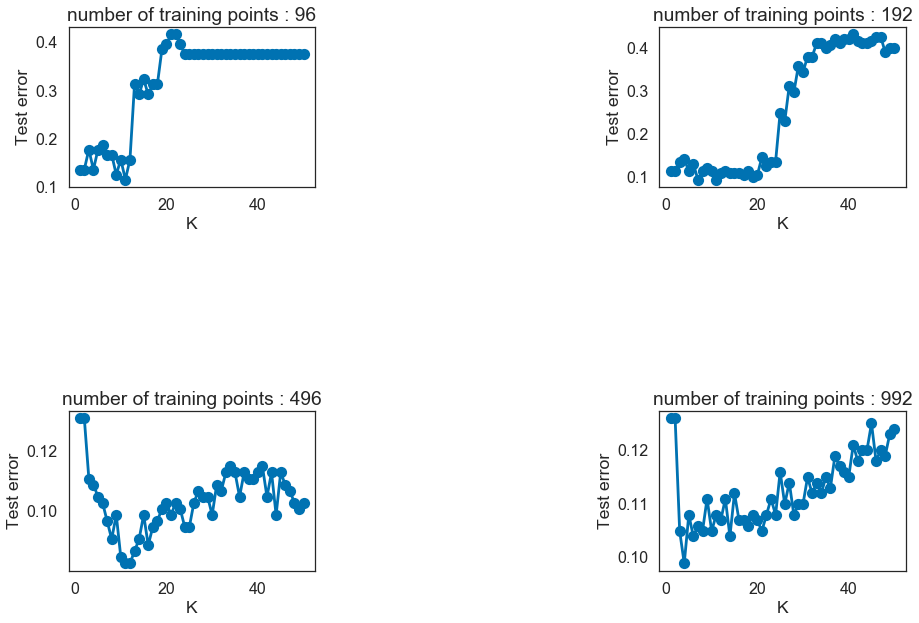

In [11]:
n_echantillons = [100,200,500,1000]
plt.close()
plt.figure(figsize=(15,10))
checker_subplt = [331,333,337,339]
k = 0
for n in n_echantillons:
    n1 = n / 2
    n2 = n / 2
    sigma = 0.1
    X5,y5 = rand_checkers(n1,n2,sigma)
    X6,y6 = rand_checkers(n1,n2,sigma)
    errorCurve = ErrorCurve(k_range=range(1,51), weights=custom_weight)
    errorCurve.fit_curve(X5,y5,X6,y6)
    plt.subplot(checker_subplt[k])
    errorCurve.plot()
    nnb = errorCurve.k_range[np.argmin(errorCurve.errors)]
    print("Pour n = " + str(n) + " échantillons, k = " + str(nnb) + " est la meilleure valeur")
    k += 1
    

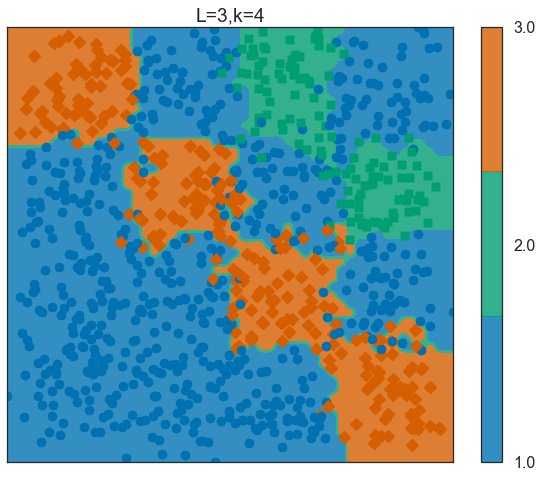

In [12]:
plt.close()
plt.figure(figsize=(10,8))
plot_2d(X5,y5)
weighted_knn_2 = neighbors.KNeighborsClassifier(n_neighbors= nnb, weights=custom_weight)
weighted_knn_2.fit(X5,y5)
def f(xx):
    return weighted_knn_2.predict(xx.reshape(1, -1))   
frontiere_new(f,X5,y5, w=None, step=50, alpha_choice=1, n_labels=n_labels,
                  n_neighbors=nnb)

### Question 11 
A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins :
temps de calcul ? passage à l’échelle ? interprétabilité ?

 
<div style="border-style:dotted; border-width:2px; padding: 25px 50px;">**Pros:**

<div><ul><li> Simple à comprendre et à implémenter.</li>

<li> On peut l'utiliser sans à priori sur la distribution des données</li>
</ul>
</div>
<div>
**Cons:**
<ul>
<li> Sensible aux données locales. Comme cette méthode fait un choix à partir des informations de ses voisins uniquement, une anomalie locale va grandement influencer le résultat.
</li>
<li> Le temps de calcul lors du trainig peut être long si le dataset de train est important.
</li>
</ul>
</div>
</div>

### Question 12
Étudiez la base digits de scikit-learn. On pourra se référer à http://scikit-learn.org/stable/_downloads/plot_digits_classification.py pour le chargement et la manipulation de la base
de données. Pour de plus amples informations sur la nature de la classe 'Bunch' (une sous-classe de
dictionnaire, on se reportera à la documentation sur la classe 'dict' : http://docs.python.org/2/library/stdtypes.html#mapping-types-dict. Décrivez la nature et le format des données
(précisément), affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon
en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième
pour le test. Appliquez la méthode aux données issues de la base digits pour un choix de k ≥ 1
(e.g., k = 30) et indiquez le taux d’erreur.

<class 'sklearn.utils.Bunch'>
Dictionary-like object, the interesting attributes are: 
-‘data’, les données à apprendre 
-‘images’, les images correspondant à chaque échantillon, 
-‘target’, les labels pour chaque échantillon, 
-‘target_names’, la signification des labels 
-‘DESCR’, la description complete du dataset.


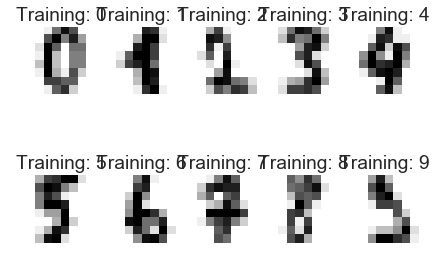

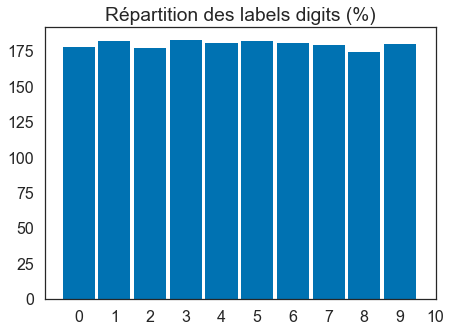

Taux d'erreur : 0.0745272525028


In [13]:
# The digits dataset:
# from sklearn import datasets
digits = datasets.load_digits()

print(type(digits))
print("Dictionary-like object, the interesting attributes are: \n-‘data’, les données à apprendre \n-‘images’, les images correspondant à chaque échantillon, \n-‘target’, les labels pour chaque échantillon, \n-‘target_names’, la signification des labels \n-‘DESCR’, la description complete du dataset.")
# A Bunch is a subclass of 'dict' (dictionary)
# help(dict)
# see also "http://docs.python.org/2/library/stdtypes.html#mapping-types-dict"

plt.close()
plt.figure()
for index, (img, label) in enumerate(list(zip(digits.images, digits.target))[10:20]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: ' + str(label))

plt.figure()
bins = np.arange(11) - 0.5
plt.hist(digits.target, rwidth=0.9, bins=bins)
plt.xticks(range(11))
plt.title("Répartition des labels digits (%)")
plt.show()

n_samples = len(digits.data)

X_train = digits.data[:n_samples // 2]
Y_train = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]

knn_digit = neighbors.KNeighborsClassifier(n_neighbors=30)
knn_digit.fit(X_train, Y_train)

error =  1 - knn_digit.score(X_test, Y_test)
print('Taux d\'erreur : ' + str(error))

### Question 13
Estimez la matrice de confusion (P{Y = i, Ck(X) = j})i, j associée au classifieur Ck ainsi
obtenu et visualisez celle-ci. Pour la manipulation de telles matrices avec scikit-learn, on
pourra consulter http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html.

Matrice de confusion, sans normalisation


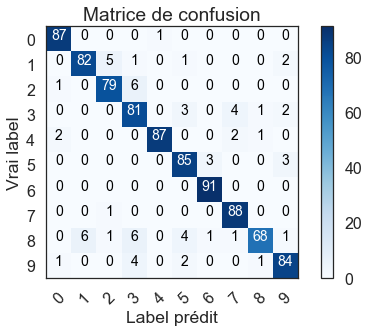

In [14]:
cm = metrics.confusion_matrix(Y_test, knn_digit.predict(X_test))
class_names = digits.target_names
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Matrice de confusion, sans normalisation')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Vrai label')
    plt.xlabel('Label prédit')
    plt.tight_layout()
plt.close()
plot_confusion_matrix(cm,class_names)

### Question 14
Proposez une méthode pour choisir k et mettez-la en œuvre. Vous pourrez utiliser la classe fournie
LOOCurve. En utilisant toutes les données, tracez la courbe du taux d’erreur *leave-one-out* pour
k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200.

on voit que pour k = 1 et k= 6 le score est le meilleur


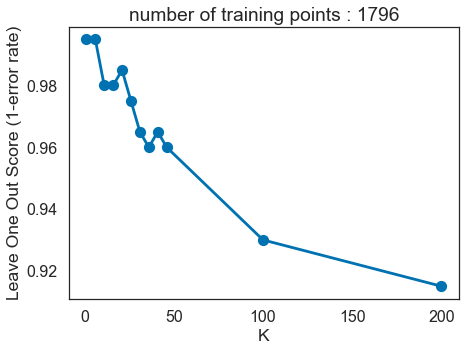

In [15]:
k_range = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
n_samples = len(digits.images)
X_images = digits.images.reshape((n_samples, -1))
y_images = digits.target
looCurve = LOOCurve(k_range=k_range)
looCurve.fit_curve(X_images,y_images)
plt.close()
looCurve.plot()
print("on voit que pour k = 1 et k= 6 le score est le meilleur")

# Analyse Discriminante Linéaire

## Aspects théoriques
***
### Question 15 
En utilisant la formule de Bayes donner la formule des probabilités a posteriori : P{Y = +1 | X = x},
P{Y = −1 | X = x}, comme fonctions de f+, f− et π+.

D'après la formule de Bayes :  

\begin{align*}
  &P(Y=+1 \mid X=x) = \frac{f_{+} \times \pi_{+}}{P(X=x)} \\ 
  &P(Y=+1 \mid X=x) = \frac{f_{+} \times \pi_{+}}{f} 
\end{align*} 

De plus on a : 
\begin{align*}
  &P(Y=-1 \mid X=x) = \frac{f_{-} \times \pi_{-}}{P(X=x)} \\ 
  &P(Y=-1 \mid X=x) = \frac{f_{-} \times (1-\pi_{+})}{f} 
\end{align*}

### Question 16 
Exprimer le log-ratio des deux classes : $log(\frac{P(Y=+1 | X=x)}{P(Y=-1 | X=x)})$ en fonction de $\mu_{+}, \mu_{+}, \pi_{+}$ et $\Sigma$  

\begin{equation*}
   log(\frac{P(Y=+1 \mid X=x)}{P(Y=-1 \mid X=x)})= \frac12 \times [(x-\mu_{-})^{T}\Sigma^{-1}(x-\mu_{-})-(x-\mu_{+})^{T}\Sigma^{-1}(x-\mu_{+})] + log(\frac{\pi_{+}}{1-\pi_{+}})
  \end{equation*}

### Question 17
 Justifier le choix du classifieur suivant : 
![image.png](image.png)

La frontière correspond à l'enssemble des points $x$ vérifiant :  
\begin{equation*}P(Y=+1 \mid X=x) = P(Y=-1 \mid X=x)\end{equation*}  
Ainsi une nouvelle observation $x$ ayant le label +1 ($Y=+1$) doit vérifier : 
\begin{equation} P(Y=+1 \mid X=x) > P(Y=-1 \mid X=x)\end{equation}
\begin{equation} \iff \frac{P(Y=+1 \mid X=x)}{P(Y=-1 \mid X=x)} > 1 \end{equation}
\begin{equation} \iff log(\frac{P(Y=+1 \mid X=x)}{P(Y=-1 \mid X=x)}) > 0 \end{equation}
On a vu dans la question précédente une autre écriture de l'équation ci dessus : 
\begin{equation} \frac12 \times [(x-\mu_{-})^{T}\hat{\Sigma}^{-1}(x-\hat{\mu}_{-})-(x-\hat{\mu}_{+})^{T}\hat{\Sigma}^{-1}(x-\hat{\mu}_{+})] + log(\frac{\pi_{+}}{1-\pi_{+}}) > 0\end{equation}
\begin{equation} \iff x^T \hat{\Sigma}^{-1}(\hat{\mu}_{+} - \hat{\mu}_{-}) - \frac12 \times (\hat{\mu}^T_{+} \hat{\Sigma}^{-1}\hat{\mu}^T_{+} - \hat{\mu}^T_{-} \hat{\Sigma}^{-1}\hat{\mu}^T_{-}) + log(\frac{\pi_{+}}{1-\pi_{+}}) > 0\end{equation}
\begin{equation} \iff x^T \hat{\Sigma}^{-1}(\hat{\mu}_{+} - \hat{\mu}_{-}) > \hat{\mu}^T_{-} \hat{\Sigma}^{-1}\hat{\mu}^T_{-}) - log(\frac{\pi_{+}}{1-\pi_{+}})  \end{equation}
\begin{equation} \iff x^T \hat{\Sigma}^{-1}(\hat{\mu}_{+} - \hat{\mu}_{-}) > \hat{\mu}^T_{-} \hat{\Sigma}^{-1}\hat{\mu}^T_{-}) - log({\pi_{+}}) - log({1-\pi_{+}})  \end{equation}

or $\pi_{+} = \frac mn$ Ainsi on a bien le classifieur  : 

\begin{Bmatrix} 1& si & x^T \hat{\Sigma}^{-1}(\hat{\mu}_{+} - \hat{\mu}_{-}) > \hat{\mu}^T_{-} \hat{\Sigma}^{-1}\hat{\mu}^T_{-}) - log({\frac mn}) - log({1-\frac mn})\\ -1 & sinon  \end{Bmatrix} 

## Mise en oeuvre
***
### Question 18
 Écrivez votre propre classe LDAClassifier avec les méthodes d’apprentissage fit et de classification
predict

In [16]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.w = None
    
    def fit(self,X,y):
        xi_pos = []
        xi_neg = []
        for x_i,y_i in zip(X,y):
            if y_i == 1:
                xi_pos.append(x_i)
            else:
                xi_neg.append(x_i)
        
        var_pos = sum(xi_pos) / len(xi_pos)
        var_neg = sum(xi_neg) / len(xi_neg)
        
        sigma_pos = np.transpose((X - var_pos)).dot(X - var_pos)
        sigma_neg = np.transpose((X - var_neg)).dot(X - var_neg) 
        sigma = ((((len(xi_neg) - 1) * sigma_pos) + (len(xi_pos) - 1) * sigma_neg)) / (len(X) - 2)
        sigma_inv = np.linalg.inv(sigma)
        
        threshold = (0.5 * np.transpose(var_pos).dot(sigma_inv).dot(var_pos) - 0.5 * np.transpose(var_neg).dot(sigma_inv).dot(var_neg + np.log(1-len(xi_pos)/len(X)) - np.log(len(xi_pos)/len(X))))
        
        self.var_pos = var_pos
        self.var_neg = var_neg
        self.sigma_inv = sigma_inv
        self.threshold = threshold
    
    def predict(self,X_pred):
        pred = []
        for x_pred in X_pred:
            if np.transpose(x_pred).dot(self.sigma_inv).dot(self.var_pos - self.var_neg) > self.threshold :
                pred.append(1)
            else:
                pred.append(-1)
        return pred
    
    def score(self,X_pred,y):
        return np.mean(np.equal(self.predict(X_pred),y))       

### Question 19
 Importez le module sklearn.discriminant_analysis qui contient en particulier la classe
LinearDiscriminantAnalysis qui nous servira dans la suite


Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe
LinearDiscriminantAnalysis de scikit-learn en utilisant un jeu de données simulé. Vous proposerez
votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon
de validation doit être assez grand ; on considère par ailleurs que m est différent de n − m,
i.e., les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez
les taux d’erreur de LDAClassifier et de LinearDiscriminantAnalysis et le nombre de cas où les
prédictions coïncident. En utilisant votre classe LDAClassifier, visualisez la règle de classification.
(Vous pouvez utiliser la fonction frontiere_new.)

In [17]:
def fLDA(xx):
    return my_LDA.predict(xx.reshape(1,-1))
n1 = 200
n2 = 300
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X7, y7 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)
X7_train = X7[:len(X7) // 20]
y7_train = y7[:len(y7) // 20]
X7_test = X7[len(X7) // 20:]
y7_test = y7[len(X7) // 20:]

LDA_sklearn = LinearDiscriminantAnalysis()
LDA_sklearn.fit(X7_train,y7_train)

my_LDA = LDAClassifier()
my_LDA.fit(X7_train,y7_train)
my_LDA.score(X7_test,y7_test)
print("Taux d'erreur pour LDAClassifier : " + str( 1 - my_LDA.score(X7_test,y7_test)))
print("Taux d'erreur pour LinearDiscriminantAnalisys (sklearn) : " + str( 1 - LDA_sklearn.score(X7_test,y7_test)))
print("Nombre de cas où les prédicitons coïncident : " + str(len(X7_test[np.equal(my_LDA.predict(X7_test),LDA_sklearn.predict(X7_test))])))
print('Nombre total de prediction :' + str(len(X7_test)) + '.\n Il y a donc une similitude de ' + str(len(X7_test[np.equal(my_LDA.predict(X7_test),LDA_sklearn.predict(X7_test))]) / len(X7_test) * 100) + "% dans la prédiction" )

Taux d'erreur pour LDAClassifier : 0.0652631578947
Taux d'erreur pour LinearDiscriminantAnalisys (sklearn) : 0.0673684210526
Nombre de cas où les prédicitons coïncident : 472
Nombre total de prediction :475.
 Il y a donc une similitude de 99.36842105263159% dans la prédiction


### Question 20
 En utilisant votre classe **LDAClassifier**, visualisez la règle de classification pour les jeux de données
#1 et #3. (Vous pouvez utiliser la fonction frontiere_new.) Discutez l’efficacité de la méthode
dans ces deux cas.

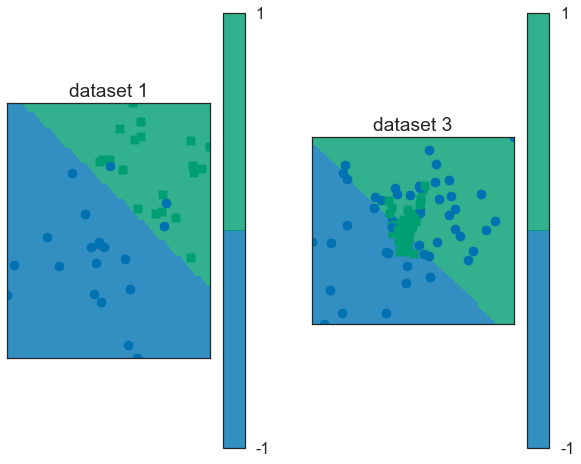

In [18]:
plt.close()
plt.figure(figsize=(10,8))
X_list = [X1,X3]
y_list = [y1,y3]
dataset_number = [1,3]
for i in range(2):
    plt.subplot(121 + i)
    plot_2d(X_list[i],y_list[i])
    frontiere_new(fLDA,X_list[i],y_list[i], w =None)
    plt.title("dataset " + str(dataset_number[i]))
plt.show()

## Méthode discriminative avec régression logistique
***
### Question 21
Appliquez la classification par régression logistique sur les données **rand_bi_gauss**. Comparer les
résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup
moins d’observations). On parle alors de classes déséquilibrées

In [19]:
n1 = 20
n2 = 3000
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X8, y8 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X8_train = X8[:len(X8) // 2]
y8_train = y8[:len(y8) // 2]
X8_test = X8[len(X8) // 2:]
y8_test = y8[len(y8) // 2:]
LR = linear_model.LogisticRegression()
LR.fit(X8_train,y8_train)
LR_error = 1 - LR.score(X8_test,y8_test)

LDA = LinearDiscriminantAnalysis()
LDA.fit(X8_train,y8_train)
LDA_error = 1 - LDA.score(X8_test,y8_test)
print("erreur pour la regression logistique : " + str(LR_error))
print("erreur pour l'analyse discriminante linéaire' : " + str(LDA_error))

erreur pour la regression logistique : 0.00264900662252
erreur pour l'analyse discriminante linéaire' : 0.00264900662252


> On remarque que dans le cas de classes déséquilibrées, les deux méthodes ont un taux d'erreur très faible est relativement proche l'un de l'autre

### Question 22 
À quoi correspond la variable **coef_** du modèle ? **intercept_** ?

<div style="border-style:dotted; border-width:2px; padding: 25px 50px;">La frontière de décision s'écrit de la forme $\alpha + \beta^TX$. **coef_** correspond à $\beta$ et **intercept_** à $\alpha$</div>

### Question 23
Utiliser la fonction **frontiere_new** pour visualiser la frontière de décision

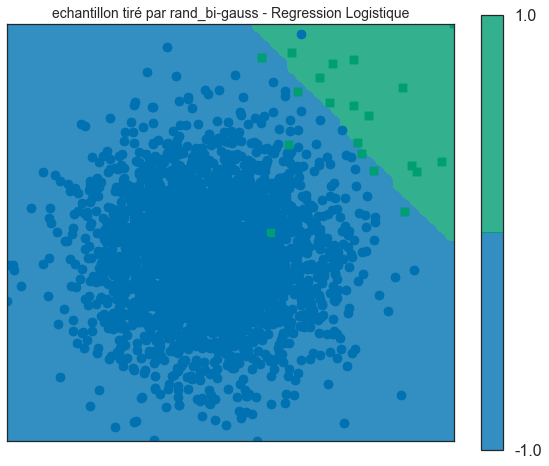

In [20]:
def fLR(xx):
    return LR.predict(xx.reshape(1,-1))
plt.close
plt.figure(figsize=(10,8))
plot_2d(X8,y8)
frontiere_new(fLR,X8,y8,w=None)
plt.title("echantillon tiré par rand_bi-gauss - Regression Logistique",fontsize=14)
plt.show()

### Question 24
 Appliquez la classification par régression logistique à des données issues de la base digits. Comme
précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie
pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur

In [21]:
LR_digit = linear_model.LogisticRegression(solver="lbfgs",multi_class='multinomial')
LR_digit.fit(X_train,Y_train)
LR_score = np.mean(np.equal(LR_digit.predict(X_test),Y_test))
print("Le taux d'erreur pour la regression logistique pour le dataset digits est " +str(1 - LR_score))

Le taux d'erreur pour la regression logistique pour le dataset digits est 0.0711902113459
